In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
import seaborn as sns
pd.options.mode.chained_assignment = None
style.use('ggplot') or plt.style.use('ggplot')


### Units used are as in Elmer/Ice:

MPa, a, m
 

In [2]:
# Conversion to Elmer/Ice units

yearinsec = 365.25*24*60*60
rhoi = 900.0/(1.0e6*yearinsec**2)
rhow = 1000.0/(1.0e6*yearinsec**2)
g = -9.8*yearinsec**2


In [12]:
# Lists of fluxes, sigma values (in bed elevation equation) and simulation names

#fluxes = [100, 200, 300, 400, 500]
#sigmas = [4000, 8000, 12000, 16000]
#sims = ['Flux200Sigma2000', 'Flux200Sigma3000', 'Flux250Sigma3000', 'Flux300Sigma4000']
sims = ['Flux200Sigma2000', 'Flux200Sigma3000', 'Flux250Sigma3000', 'Flux300Sigma4000', 'Flux200Sigma2000_cyl', 'Flux200Sigma3000_cyl', 'Flux250Sigma3000_cyl', 'Flux300Sigma4000_cyl']


#for i in fluxes:
#    for j in sigmas:
#        sims.append('Flux' + str(i) + 'Sigma' + str(j))

dfs = {}
for sim in sims:
    dfs[sim] = pd.read_csv('../Data/StressWiderDomain/' + str(sim) + '.csv')
    

In [13]:
# Centre domain in the cylinder simualtions

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim]['Points:0'] = dfs[sim]['Points:0'] - 150000
        
        

In [14]:
# Calculate the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']
        

In [15]:
# Re-order data by the y-coordinate and the z-coordinate

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim] = dfs[sim].sort_values(by=['Points:0', 'Points:2'])
        dfs[sim] = dfs[sim].reset_index(drop=True)
    else:
        dfs[sim] = dfs[sim].sort_values(by=['Points:1', 'Points:2'])
        dfs[sim] = dfs[sim].reset_index(drop=True)
    

In [17]:
# Calculate the hydrostatic pressure at a point if the ice shelf ended at that point

for sim in sims:
    dfs[sim]['hyd. pressure'] = [0] * len(dfs[sim])

for sim in sims:
    for i in range(len(dfs[sim])):
        if dfs[sim]['Points:2'][i] < 0.0:
            dfs[sim]['hyd. pressure'][i] = - rhow * g * dfs[sim]['Points:2'][i]
        else:
            dfs[sim]['hyd. pressure'][i] = 0.0
    
# Subtract the hydrostatic pressure from stess

for sim in sims:
    dfs[sim]['stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure']
    dfs[sim]['dev stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']


In [18]:
# Function to vertically integrate data
# As input, it takes a dataframe, number of vertical nodes, variable and coordinate of interest

def VertInt(df, N, var, coord):
    field = dict.fromkeys(df[coord], 0)
    Coord = dict.fromkeys(df[coord], 0)
    for i in df[coord]:
        Coord[i] += 1
    incorrect_coord_values = [k for k, v in Coord.items() if v != N]
    correct_coord_values = [k for k, v in Coord.items() if v == N]
    for i in incorrect_coord_values:
        Coord = {i:Coord[i] for i in Coord if i not in incorrect_coord_values}
        field = {i:field[i] for i in field if i not in incorrect_coord_values}
    df = df[~df[coord].isin(incorrect_coord_values)]
    df_height0 = df[df['height'] < 0.1]
    df_depth0 = df[df['pressure'] < 0.1]
    df_other = df[df['height'] > 0.1]
    df_other = df_other[df_other['pressure'] > 0.1]
    df_height0 = df_height0.reset_index(drop=True)
    df_depth0 = df_depth0.reset_index(drop=True)
    df_other = df_other.reset_index(drop=True)
    for i in range(len(df_other)):
        field[df_other[coord][i]] += df_other[var][i]
    for i in range(len(df_height0)):
        field[df_height0[coord][i]] += 0.5 * df_height0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] += 0.5 * df_depth0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] *= df_depth0['height'][i]
    field = {k: v / (N - 1) for k, v in field.items()}
    return field


In [19]:
# Calculate vertically-integrated fields of interest

stress1 = {}
devstress1 = {}
stress1hydp = {}
devstress1hydp = {}
hydp = {}

for sim in sims:
    if sim.endswith('cyl'):
        stress1[sim] = VertInt(dfs[sim], 6, 'stress 2', 'Points:0')
        #devstress1[sim] = VertInt(dfs[sim], 6, 'dev stress 2', 'Points:0')
        #stress1hydp[sim] = VertInt(dfs[sim], 6, 'stress 2 - hyd. p.', 'Points:0')
        #devstress1hydp[sim] = VertInt(dfs[sim], 6, 'dev stress 2 - hyd. p.', 'Points:0')
        #hydp[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:0')
    else:
        stress1[sim] = VertInt(dfs[sim], 6, 'stress 1', 'Points:1')
        devstress1[sim] = VertInt(dfs[sim], 6, 'dev stress 1', 'Points:1')
        stress1hydp[sim] = VertInt(dfs[sim], 6, 'stress 1 - hyd. p.', 'Points:1')
        devstress1hydp[sim] = VertInt(dfs[sim], 6, 'dev stress 1 - hyd. p.', 'Points:1')
        hydp[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:1')


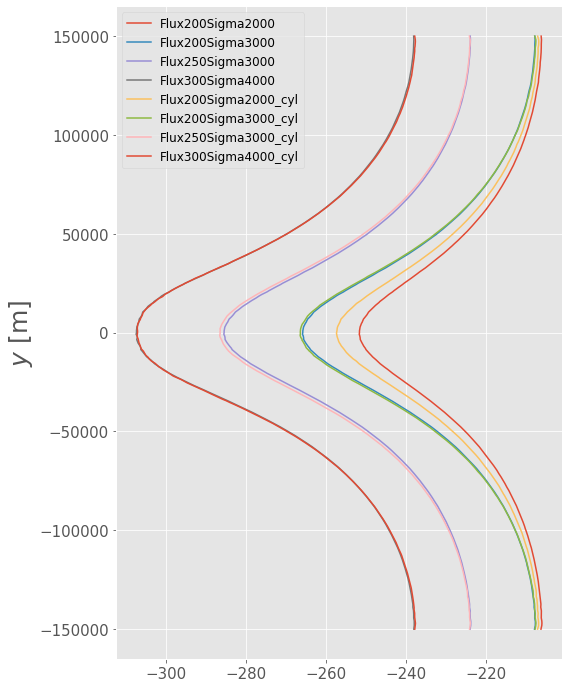

In [20]:
# Plot the deviatoric stress in the x-direction

fig, ax = plt.subplots(1, 1, figsize=(8, 12))

for sim in sims:
    ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim)  
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='12')
#ax.title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
#ax.set_xlabel(r'$\tau_{xx}$ [MPa]', size=25)
#fig.savefig('../Figures/stress1_sigma.jpg', format='jpg', dpi=500, bbox_inches = "tight")